To run this example notebook:
* pandas, numy, biopython are needed for this notebook.
* bacteria model files and lshvec java library are required to be downloaded (refer to project README)
* install PyLSHVec (pip, docker or from code)
* Be warning that jnius may not work on your environment. Refer to https://github.com/kivy/pyjnius for trouble shooting.

To make this notebok easier, it does not use multiple therads for prediction. However it also makes the notebook slow.

In [1]:
%pylab inline
import sys,os
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
if 0: #dirty fix
    sys.path.insert(0,"../src/")
    os.environ['JAVA_HOME']='/usr/lib/jvm/java-openjdk/'

In [4]:
from pylshvec import *

In [5]:
#here needs jlshvec jar file, download it first
set_lshvec_jar_path("/mnt/jlshvec-assembly-0.1.jar")

In [6]:
#since vector model is usually large, set a big java memory limit is preferred. 
add_java_options("-Xmx48G")

In [7]:
#here need model file and lsh function file, download them first
model= LSHVec(model_file="/mnt/genbank_model_ill_k23_model_299", hash_file="/mnt/lsh_CAMI2_illumina_k23_h25.crp")

In [8]:
#To show some parameters
getIgnores = ['getRank', 'getName', 'getTaxIdPath', 'getTaxNamePath']
for u in dir(model):
    if not u in getIgnores:
        if u.startswith('get') or u.startswith('is'):
            fun = getattr(model, u)
            print(u, fun())

getBatchsize 1024
getKmerSize 23
getMaxItems 500
getNumThread 1
getThreshold 0.004999999888241291
getVecDim 100
isInitialized True
isOnlyShowLeaf False
isOnlyShowMainTax True
isWithoutUncult True


In [12]:
#to show information for a taxonomy id
# All taxonomiy ids are ncbi taxonomy ids, except dummy id
for u in getIgnores:
    fun = getattr(model, u)
    print(u, fun(1421531))

getRank no rank
getName Pseudomonas aeruginosa 0C2E
getTaxIdPath [1, 3000001, 3019651, 131567, 3234078, 2, 3234080, 3234083, 3234944, 3234946, 1224, 3234949, 3236885, 3244539, 1236, 3340569, 3357417, 3392893, 3398780, 72274, 3398783, 3398789, 135621, 3407233, 3407383, 3407407, 286, 3407410, 3407412, 3407414, 3407417, 3409822, 3409825, 3410337, 3410592, 3410594, 3410596, 3410598, 3410600, 3410602, 3410604, 136841, 3410607, 3410629, 3410635, 287, 3410636, 3410639, 3410772, 3410775, 3410802, 3410805, 3410810, 3410813]
getTaxNamePath ['root', 'dummy3000001', 'dummy3019651', 'cellular organisms', 'dummy3234078', 'Bacteria', 'dummy3234080', 'dummy3234083', 'dummy3234944', 'dummy3234946', 'Proteobacteria', 'dummy3234949', 'dummy3236885', 'dummy3244539', 'Gammaproteobacteria', 'dummy3340569', 'dummy3357417', 'dummy3392893', 'dummy3398780', 'Pseudomonadales', 'dummy3398783', 'dummy3398789', 'Pseudomonadaceae', 'dummy3407233', 'dummy3407383', 'dummy3407407', 'Pseudomonas', 'dummy3407410', 'dummy

From [NCBI website](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi) we see that the lineage of 141531 is "Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas"

In [13]:
def random_dna_sequence(length):
    return ''.join(np.random.choice(list('ACTG')) for _ in range(length))

def add_substitute_error(seq, err_rate=0.05):
    return "".join(    np.random.choice(list('ACTG'))  if np.random.random()<err_rate else u for u in seq )
def random_sub_seq(seq,length=500):
    assert len(seq)>length
    i=int(np.random.random()*(len(seq)-length))
    return seq[i:i+length]
def predict(seq):
    pred=pd.Series(model.predict(seq), name='prob')
    pred.index.name='taxid'
    pred=pred.to_frame()
    pred['rank']=pred.index.map(lambda u: model.getRank(u))
    pred['name']=pred.index.map(lambda u: model.getName(u))
    return pred.sort_values("prob",ascending=False)

### let's play with an assembly  for [Pseudomonas aeruginosa](https://www.ncbi.nlm.nih.gov/assembly/GCF_001500235.1/) whose taxid is 1421531.

In [14]:
url="ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/500/235/GCA_001500235.1_ASM150023v1/GCA_001500235.1_ASM150023v1_genomic.fna.gz"

In [23]:
#download the sequence
import urllib 
from Bio import SeqIO
import gzip
with  urllib.request.urlopen(url) as handle_url :
    with gzip.open(handle_url, 'rt') as handle:
        for i,record in enumerate(SeqIO.parse(handle, "fasta")):
            print(record.id, len(record))
            if i==1: break
            

LNBU01000001.1 458883
LNBU01000002.1 484767


In [24]:
seq=str(record.seq)
print ("The sequence length is {}".format(len(seq)))


The sequence length is 484767


##### Look at how the model predict on the  seq. Note that we only make predictions on main ranks. (actually it does not work good on strain level)

In [26]:
pred = predict(seq)

#### Let's see the prediction for non-species ranks below. Recall the lineage is "Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas".  It seems the prediction is good here.

In [30]:
pred[pred['rank']!='species'].head(12)

,prob,rank,name
taxid,,,
2,0.9994,superkingdom,Bacteria
1224,0.8811,phylum,Proteobacteria
1236,0.8347,class,Gammaproteobacteria
72274,0.8195,order,Pseudomonadales
135621,0.8191,family,Pseudomonadaceae
286,0.8186,genus,Pseudomonas
201174,0.1054,phylum,Actinobacteria
1760,0.1049,class,Actinobacteria
85007,0.0311,order,Corynebacteriales


#### However for species, the probability seems equally spreads on many taxids. This because the train data of this model samples only one assembly for each species. These species are so similar to each other that it is hard to differentiate them in species level.

In [31]:
pred[pred['rank']=='species'].head(20)

,prob,rank,name
taxid,,,
1739343,0.0273,species,Pseudomonas sp. HMSC067F09
1739344,0.0271,species,Pseudomonas sp. HMSC076A12
1739410,0.0268,species,Pseudomonas sp. HMSC065H02
1739334,0.0264,species,Pseudomonas sp. HMSC066B03
1739293,0.0261,species,Pseudomonas sp. HMSC067D05
1739418,0.0260,species,Pseudomonas sp. HMSC067G02
1715094,0.0250,species,Pseudomonas sp. HMSC070B12
1715014,0.0241,species,Pseudomonas sp. HMSC060G01
1739451,0.0238,species,Pseudomonas sp. HMSC069G05


#### You may go to another notebook, the model in which uses does not sample sepcies, to see it works well for species 287 which has a lot strain assemblies.  

#### Anyway data plays an important role in machine learning models. Keep it in mind when you use a pre-train model.

#### We does not care about species prediction in this notebook anymore.

### All the above work on the whole sequence. How about for sub sequences? 

In [34]:
predict(random_sub_seq(seq,300)).head(10)

,prob,rank,name
taxid,,,
2,0.9993,superkingdom,Bacteria
1224,0.8934,phylum,Proteobacteria
1236,0.8785,class,Gammaproteobacteria
72274,0.8623,order,Pseudomonadales
135621,0.8577,family,Pseudomonadaceae
286,0.8559,genus,Pseudomonas
201174,0.0756,phylum,Actinobacteria
1760,0.0748,class,Actinobacteria
1739344,0.0451,species,Pseudomonas sp. HMSC076A12


### It is not bad for a 300-length sequence.

### We are going to show the mean prediction probabilities for tax 286 for various subseq length.

In [35]:
def mean_prob(seq_len=500, target_taxid=286):
    prob_list=[]
    for i in range(0,len(seq)-seq_len,int(seq_len/2)):
        aseq = seq[i:i+seq_len]
        pred = model.predict(aseq)
        if target_taxid in pred:
            prob_list.append(pred[target_taxid])
        else:
            prob_list.append(0)
    return np.mean(prob_list)


In [36]:
lengths =list( range(100,500,25))
probs=[mean_prob(seq_len=u) for u in lengths]

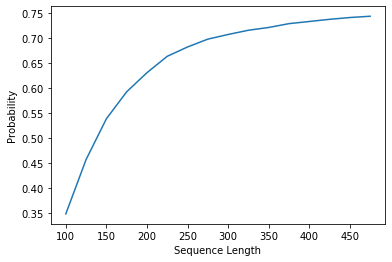

In [37]:
plt.plot(lengths,probs)
plt.ylabel("Probability")
plt.xlabel("Sequence Length");